In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    BertTokenizer, RobertaTokenizer, XLMRobertaTokenizer,
    AutoModelForSequenceClassification, TrainingArguments, Trainer
)
import evaluate
from sklearn.model_selection import train_test_split

/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [3]:
train, val = train_test_split(train_df, test_size=0.2, stratify=train_df['Sentiment'], random_state=42)

In [4]:
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)

label_list = sorted(train_df['Sentiment'].unique())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
num_labels = len(label_list)

def encode_labels(example):
    example['labels'] = label2id[example['Sentiment']]
    return example

train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)



Map: 100%|██████████| 118/118 [00:00<00:00, 32042.46 examples/s]


In [5]:
bert_tok = BertTokenizer.from_pretrained('bert-base-cased')                # WordPiece
roberta_tok = RobertaTokenizer.from_pretrained('roberta-base')             # BPE
xlmr_tok = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')         # SentencePiece

In [6]:
def tok_bert(example):
    return bert_tok(example['Text'], truncation=True, padding='max_length', max_length=64)

def tok_roberta(example):
    return roberta_tok(example['Text'], truncation=True, padding='max_length', max_length=64)

def tok_xlmr(example):
    return xlmr_tok(example['Text'], truncation=True, padding='max_length', max_length=64)


In [7]:
print("Original text:")
print(train_dataset[0]['Text'])


print("Tokenized text:")
print("Word piece:", bert_tok.tokenize(train_dataset[0]['Text']))
print("BPE: ",roberta_tok.tokenize(train_dataset[0]['Text']))
print("Sentence piece:", xlmr_tok.tokenize(train_dataset[0]['Text']))

Original text:
Basking in the golden glow of contentment, a serene river flowing through the landscape of the heart.
Tokenized text:
Word piece: ['Ba', '##skin', '##g', 'in', 'the', 'golden', 'glow', 'of', 'content', '##ment', ',', 'a', 'se', '##rene', 'river', 'flowing', 'through', 'the', 'landscape', 'of', 'the', 'heart', '.']
BPE:  ['B', 'asking', 'Ġin', 'Ġthe', 'Ġgolden', 'Ġglow', 'Ġof', 'Ġcontent', 'ment', ',', 'Ġa', 'Ġse', 'rene', 'Ġriver', 'Ġflowing', 'Ġthrough', 'Ġthe', 'Ġlandscape', 'Ġof', 'Ġthe', 'Ġheart', '.']
Sentence piece: ['▁Bas', 'king', '▁in', '▁the', '▁golden', '▁glo', 'w', '▁of', '▁content', 'ment', ',', '▁a', '▁ser', 'ene', '▁river', '▁flow', 'ing', '▁through', '▁the', '▁landscape', '▁of', '▁the', '▁heart', '.']


In [8]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.argmax(axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

def train_and_eval(model_name, tokenizer_func):
    tokenized_train = train_dataset.map(tokenizer_func, batched=True).remove_columns(['Text'])
    tokenized_val = val_dataset.map(tokenizer_func, batched=True).remove_columns(['Text'])
    tokenized_train.set_format('torch')
    tokenized_val.set_format('torch')

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        disable_tqdm=False
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=bert_tok,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer.evaluate(), trainer.state.log_history


In [ ]:
results = {}
loss = {}

results['BERT'], loss['BERT'] = train_and_eval('bert-base-cased', tok_bert)
results['RoBERTa'], loss['RoBERTa'] = train_and_eval('roberta-base', tok_roberta)
results['XLM-R'], loss['XLM-R'] = train_and_eval('xlm-roberta-base', tok_xlmr)

results

Map: 100%|██████████| 118/118 [00:00<00:00, 7009.61 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9z/qbb7p8850wn4s2gy2m9b11sh0000gn/T/ipykernel_7461/3884456743.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.345500,0.415922,0.847458,0.548853
2,0.466700,0.398326,0.855932,0.644515
3,0.225200,0.391306,0.864407,0.694498
4,0.132900,0.412221,0.864407,0.675824
5,0.092600,0.400140,0.864407,0.710784


/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Map: 100%|██████████| 118/118 [00:00<00:00, 5824.94 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9z/qbb7p8850wn4s2gy2m9b11sh0000gn/T/ipykernel_7461/3884456743.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None, 'pad_token_id': 0}.
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/pyt

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.384000,0.421578,0.838983,0.456221
2,0.481600,0.351408,0.838983,0.456221
3,0.254600,0.300295,0.881356,0.716346
4,0.198400,0.341489,0.889831,0.758615
5,0.124600,0.315576,0.898305,0.793826


/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Map: 100%|██████████| 118/118 [00:00<00:00, 13914.98 examples/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9z/qbb7p8850wn4s2gy2m9b11sh0000gn/T/ipykernel_7461/3884456743.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None, 'pad_token_id': 0}.
/Users/derwinrustanly/Code/Python/NLP/.venv

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.393700,0.481055,0.838983,0.456221
2,0.516100,0.427302,0.838983,0.456221
3,0.443000,0.377717,0.838983,0.456221
4,0.386900,0.378462,0.838983,0.456221
5,0.260700,0.335177,0.838983,0.456221


/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/derwinrustanly/Code/Python/NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

{'BERT': {'eval_loss': 0.3913058340549469,
  'eval_accuracy': 0.864406779661017,
  'eval_f1': 0.6944983818770227,
  'eval_runtime': 0.784,
  'eval_samples_per_second': 150.508,
  'eval_steps_per_second': 10.204,
  'epoch': 5.0},
 'RoBERTa': {'eval_loss': 0.30029523372650146,
  'eval_accuracy': 0.8813559322033898,
  'eval_f1': 0.7163461538461539,
  'eval_runtime': 0.801,
  'eval_samples_per_second': 147.307,
  'eval_steps_per_second': 9.987,
  'epoch': 5.0},
 'XLM-R': {'eval_loss': 0.3351769745349884,
  'eval_accuracy': 0.8389830508474576,
  'eval_f1': 0.45622119815668205,
  'eval_runtime': 1.038,
  'eval_samples_per_second': 113.676,
  'eval_steps_per_second': 7.707,
  'epoch': 5.0}}

In [22]:
def plot_loss_curves(loss_dict, cols=3):
    n_models = len(loss_dict)
    rows = math.ceil(n_models / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (model_name, log_history) in enumerate(loss_dict.items()):
        log_history = pd.DataFrame(log_history)
        train_loss = log_history[log_history['loss'].notna()]
        eval_loss = log_history[log_history['eval_loss'].notna()]

        ax = axes[i]
        ax.plot(train_loss['step'], train_loss['loss'], label='Train Loss', color='tab:blue')
        ax.plot(eval_loss['step'], eval_loss['eval_loss'], label='Val Loss', color='tab:orange', linestyle='--')
        ax.set_title(f"{model_name}")
        ax.set_xlabel("Training Step")
        ax.set_ylabel("Loss")
        ax.grid(True, linestyle=":")
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

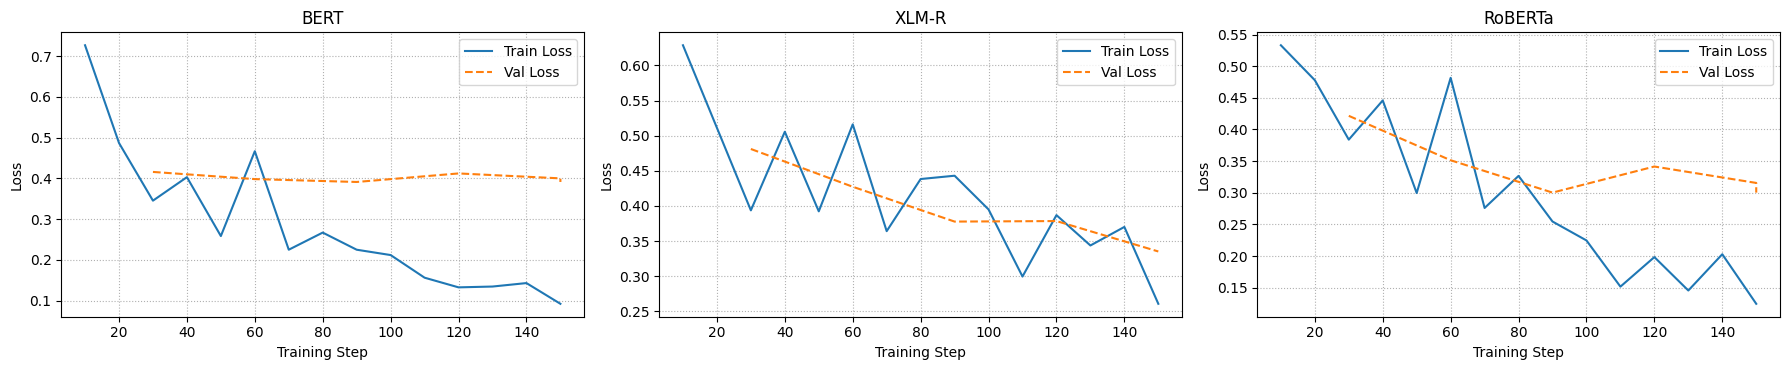

In [23]:
plot_loss_curves(loss)

In [27]:
results_df = pd.DataFrame(results).T
results_df

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
BERT,0.391306,0.864407,0.694498,0.784,150.508,10.204,5.0
RoBERTa,0.300295,0.881356,0.716346,0.801,147.307,9.987,5.0
XLM-R,0.335177,0.838983,0.456221,1.038,113.676,7.707,5.0


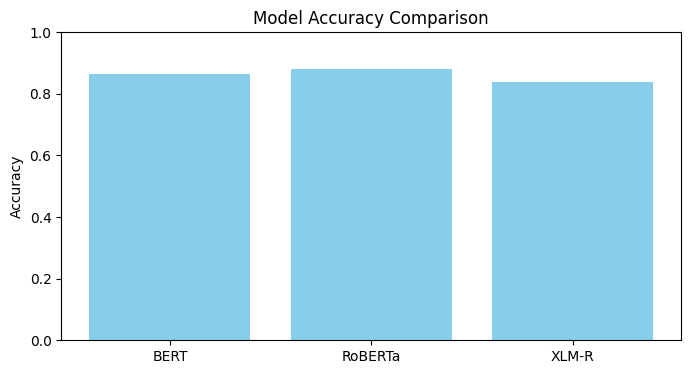

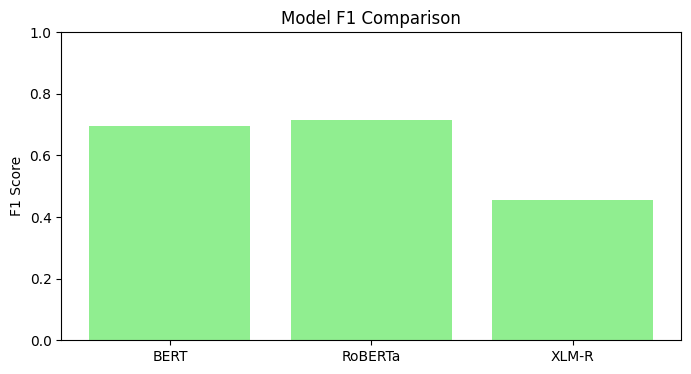

In [14]:
models = list(results.keys())
accuracies = [results[m]['eval_accuracy'] for m in models]
f1_scores = [results[m]['eval_f1'] for m in models]

plt.figure(figsize=(8,4))
plt.bar(models, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, f1_scores, color='lightgreen')
plt.ylabel('F1 Score')
plt.title('Model F1 Comparison')
plt.ylim(0,1)
plt.show()